In [1]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pylab as plt


from matplotlib.pyplot import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (15.,10)



In [2]:
########################################
# Constants and options
kgC_to_umolsCO2_factor =  (1e3/12.0107)*1e6  #(grams of substance/molar mass) * micromoles conversion
seconds_in_year = 60.*60.*24.*365.
Lc_H2O = 2.501e6


In [19]:
# Directories and Filenames
BASE_DIR='/prj/wetlands_africa/jules/JASMIN/BVOCs/SITE_DATA/'


site='BoscoFontana'
year_str='2012'
#site='AuchencorthMoss'
#year_str='2015'

ipft=0

runids=['Jv4.6_'+site+'_SM'] 

tstep='tstep'
nJULES=len(runids)
JULES_OUTPUT_DIR=BASE_DIR+'jules_runs/output/'+site+'/'
JULES_fnames=[JULES_OUTPUT_DIR+runid+'.'+tstep+'.nc' for runid in runids]

SITE_DIR=BASE_DIR+'data/'
SITE_fname=SITE_DIR+'Bosco_Fontana_Italy_Flux_Data.nc'




In [20]:
# Read Site Data
Svars=['Isoprene_flux','total_Monoterpenes_flux',\
       'pstar','RH','t','sw_down','lw_down','wind','precip','q']

Sconvfact=[1e-3*(365.*24.),1e-3*(365.*24.), \
           1,1,1,1,1,1,1,1]
Sinf=nc.Dataset(SITE_fname,'r')
S_Dict={}
for var,cf in zip(Svars,Sconvfact):
    S_Dict[var]=Sinf.variables[var][:].squeeze()*cf

# Round time to closest half an hour
roundtime= np.round(Sinf.variables['time'][:].astype('float64')/1800.)*1800.
S_time=nc.num2date(roundtime,Sinf.variables['time'].units)
del roundtime
Sinf.close()

S_panda=pd.DataFrame(S_Dict,index=S_time)



In [21]:
# Read in JULES data and convert to pandas
Jvars=['isoprene_gb','terpene_gb','lai','tstar_gb']#,'sw_down','tl1','gpp_gb']
Jconvfact=[1e3*(365*24*3600),1e3*(365*24*3600),1,1]
J_pandas=[]

for Jcnt in range(nJULES):
    print(JULES_fnames[Jcnt])
    Jinf=nc.Dataset(JULES_fnames[Jcnt],'r')

    J_Dict={}
    for var,cf in zip(Jvars,Jconvfact):
        J_Dict[var]=Jinf.variables[var][:].squeeze()*cf
        if len(J_Dict[var].shape)>1:
            J_Dict[var]=J_Dict[var][:,ipft]

    roundtime= np.round(Jinf.variables['time'][:].astype('float64')/1800.)*1800.
    J_time=nc.num2date(roundtime, Jinf.variables['time'].units)
    del roundtime
    Jinf.close()

    J_pandas.append( pd.DataFrame(J_Dict,index=J_time) )



/prj/wetlands_africa/jules/JASMIN/BVOCs/SITE_DATA/jules_runs/output/BoscoFontana/Jv4.6_BoscoFontana_SM.tstep.nc


In [22]:
ISO_panda=pd.concat( [panda['isoprene_gb'] for panda in J_pandas],axis=1)  #S_panda['isoprene']] +
ISO_panda.columns=runids   # ['Site']+

TERP_panda=pd.concat( [panda['terpene_gb']*3.6e12 for panda in J_pandas],axis=1)
TERP_panda.columns=runids

LAI_panda=pd.concat( [panda['lai'] for panda in J_pandas],axis=1)
LAI_panda.columns=runids

TSTAR_panda=pd.concat( [panda['tstar_gb'] for panda in J_pandas],axis=1)
TSTAR_panda.columns=runids

In [38]:
S_met_panda=S_panda[['pstar','RH','t','sw_down','lw_down','wind','precip','q']].resample('D').mean()

(22325760, 22366080)

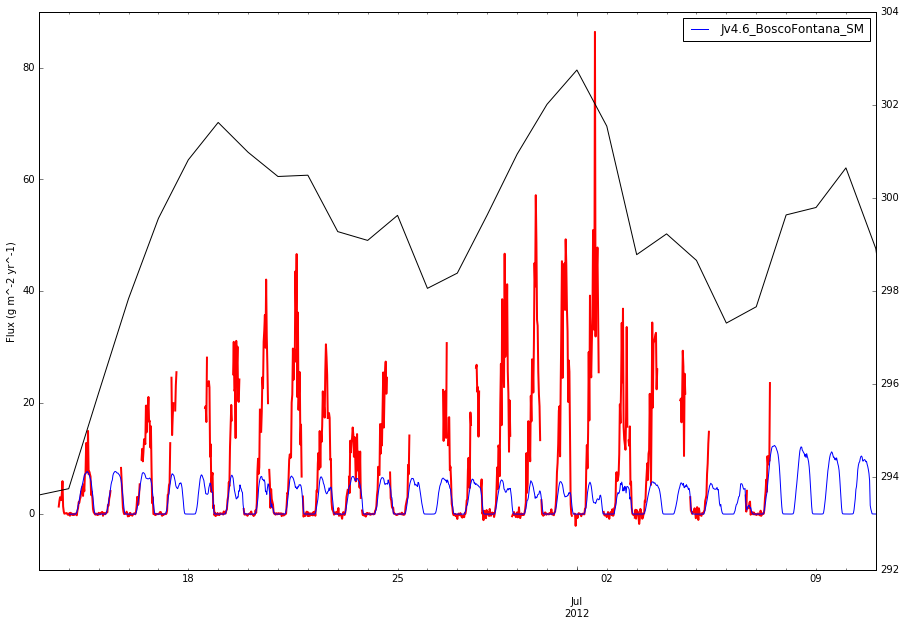

In [55]:
ax=plt.subplot(1,1,1)
S_panda['Isoprene_flux'].plot(c='r',lw=2,grid=True,ax=ax)
ISO_panda.plot(ax=ax)
plt.ylabel('Flux (g m^-2 yr^-1)')
S_panda['t'].resample('D').mean().plot(ax=ax,color='k',secondary_y=True)
plt.xlim(['2012-06-13','2012-07-11'])


(0, 4)

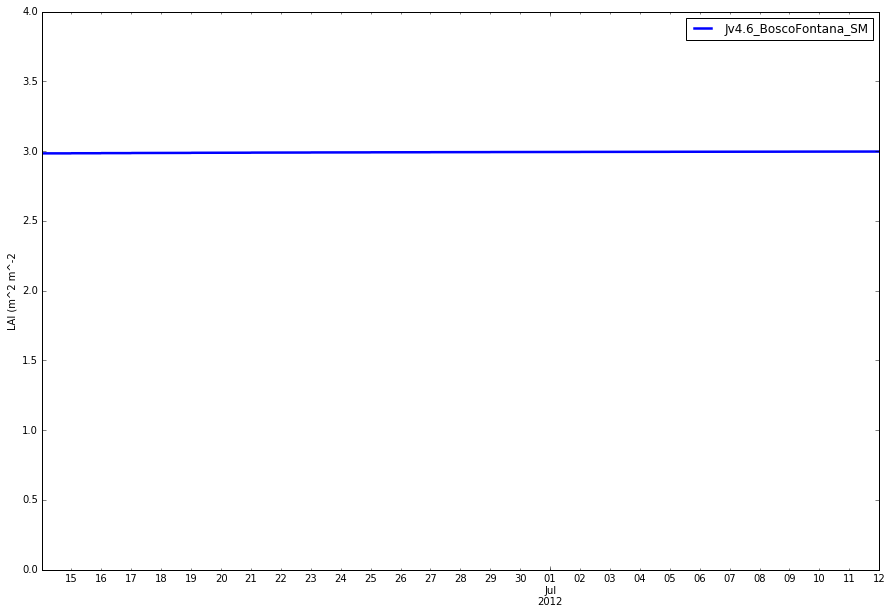

In [53]:
#TERP_panda.plot()
LAI_panda.plot(lw=2.5)
plt.ylabel('LAI (m^2 m^-2')
plt.ylim([0,4])

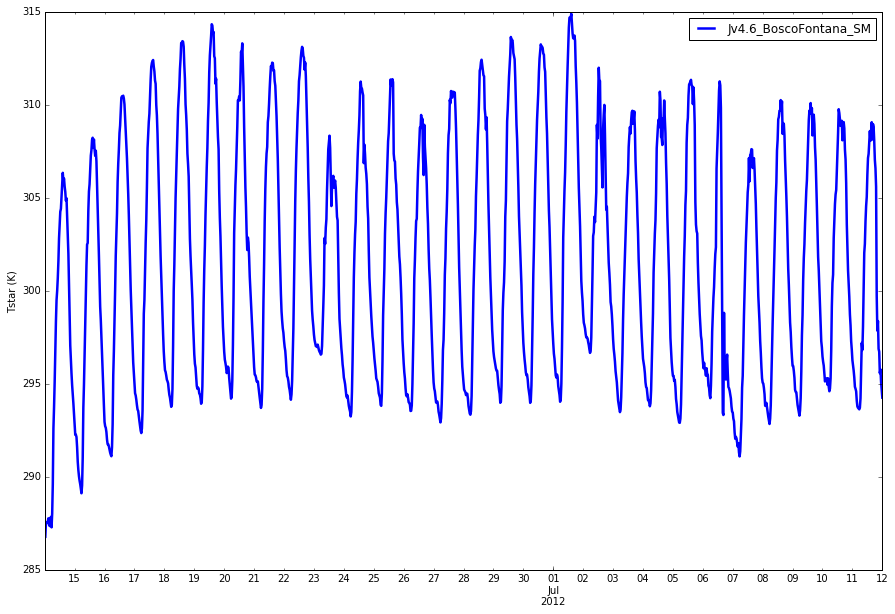

In [26]:
#TERP_panda.plot()
TSTAR_panda.plot(lw=2.5)
plt.ylabel('Tstar (K)')
